# Solute Transport
<p>This is a second attempt at the solute transport notebook. I'm not sure what happened to the first one, but I guess it's not really working anymore. I didn't really get too far into it so that's ok.</p>


<p>In this notebook, I hope to outline a method to model solute transport, including advection, diffusion, and dispersion. Solute/contaminant transport in an aquifer occurs by the combination of those three methods.</p>
<p><b>Advection</b> is the process by which solute is carried along by the bulk motion of the fluid</p>
<p><b>Diffusion</b> is the <u>microscopic</u> random motion of solute particles in the water.</p>
<p><b>Dispersion</b> is the <u>macroscopic</u> process by which solute spreads out due to nonideal flow conditions. Solute can disperse longitudinall, transversely, and vertically.</p>
<p>The general equation that we use for solute transport modelling is the <b>Advection-Dispersion Relation (ADR) Equation:</b></p>
<h3><center>$\frac{\partial C}{\partial t} = D_{x} \frac{\partial^{2} C}{\partial x^{2}} + D_{y} \frac{\partial^{2} C}{\partial y^{2}} + D_{z} \frac{\partial^{2} C}{\partial z^{2}} - v \frac{\partial C}{\partial x} - \lambda RC$</center></h3>

## A solute transport model
<p>I'll try to keep the model as simple as I can. To model tracer transport first with advection, I just need a second queue to monitor the concentration and amount of tracer in each element, which will then be carried by the motion of the water. For now, a 1D model will do.</p>
<p>In this first function, the term we are concerned with is $v \frac{\partial C}{\partial x}$, which is the advective term, where $v$ is groundwater velocity and $C$ is solute concentration.</p>
<p>This equation shouldn't be too hard to work with. $\frac{\partial C}{\partial x}$ is just equal to the difference in the concentration of two adjacent cells. The velocity $v$ can be determined just using the Darcy velocity and the porosity</p>
<p>It would probably be a good idea to use the queue as an intermediate in order to determine average velocity: $\bar{u} = \frac{q}{\theta}$</p>

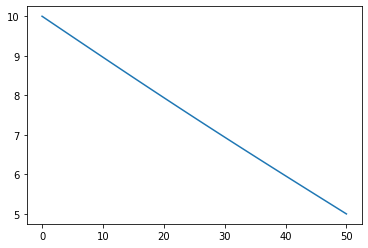

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def steadyStateUpdate(heads,queue,conductivity):
    queue[:-1] += (heads[1:] - heads[:-1])*conductivity
    queue[1:] += (heads[:-1] - heads[1:])*conductivity
    
    heads += queue
    
    return heads

def steadyStateHeads(heads,queue,conductivity):
    queue = np.zeros(queue.size)
    queue[:-1] += (heads[1:] - heads[:-1])*conductivity
    queue[1:] += (heads[:-1] - heads[1:])*conductivity
    
    return queue
    
length = 51
    
heads = np.full(length,5.0)
heads[0] = 10
heads[-1] = 5
queue = np.zeros(length)

for i in range(10000):
    queue = np.zeros(length)
    heads = steadyStateUpdate(heads,queue,.1)
    heads[0] = 10
    heads[-1] = 5
    '''
    if heads[50] <= 0:
        heads[50] = 0
    else:
        heads[50] -= .3
    '''
plt.plot(heads)
plt.show()

### Some Analysis
<p>From this example, with some constant boundary conditions, the hydraulic head will evolve to be linear. This makes the equation for $\frac{\partial C}{\partial x}$ pretty easy to determine because it's a constant. It will be the slope of the equation.</p>
<p>However, this model makes a pretty difficult assumption. It assumes that the area that the discharge passes through is equal to 1. For this condition to be true, the aquifer must be confined and have a constant height throughout, so that the head differences are due to pressure differences along the aquifer. This isn't impossible, it just means that this model cannot be used for unconfined aquifers. As for some values, it assumes that the flow area is 1, as I have not put any dimensions in the function. That will suffice for now.</p>
<p>Actually, the assumption that the aquifer is confined and that the flow area is constant makes things a bit easier: Darcy velocity is equal to discharge divided by flow area, but our function is already equal to the normalized value. So, I don't have to change any values. At steady state, all of the queue values should be zero, as the water flowing into and out of each cell is equal. Therefore, the velocity of the water into and out of each cell should be equal. The velocity of the water can be determined by:</p>
<h3><center>$v = \frac{q}{\theta}$</center></h3>
<p>For my dataset, I'll just take the average value of $q$ to use for this, which should be constant among each element. I'll use a $\theta$ value of .25.</p>

In [15]:
porosity = .25
averageQ = np.average(queue[1:-1])  # Excluding the first and last values
avgVelocity = averageQ/porosity
avgVelocity *= 100

print("The average velocity of the water through each element is {}".format(round(avgVelocity,7)))

The average velocity of the water through each element is 0.0063004


<p>Since I assume that the length of each element is 1, $\partial x$ will always be equal to 1. This simplifies the equation even further:</p>
<h3><center>$\frac{\partial C}{\partial t} = v \frac{\partial C}{\partial x} = v \Delta C = v(C_{i + 1} - C_{i})$</center></h3>
<p>Where $C$ is the concentration of solute in an individual element.</p>
<p>This equation can be simplified more somehow.</p>

[0.71013711 0.70452548 0.69343708 0.67713641 0.65600756 0.63053976
 0.6013095  0.56896002 0.53417944 0.49767849 0.46016909 0.42234464
 0.38486295 0.34833236 0.31330143 0.28025247 0.24959864 0.22168448
 0.1967893  0.17513285 0.15688247 0.14216114 0.13105547 0.12362309
 0.11989878]


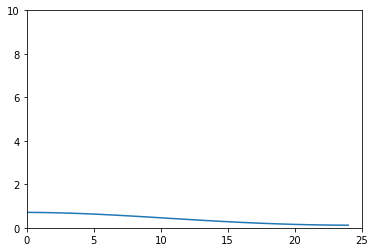

In [24]:
%matplotlib inline

def soluteTransport(concentrations, velocity, timeStep = 1):
    queue = np.zeros(concentrations.size)
    queue[:-1] += (concentrations[1:] - concentrations[:-1])*timeStep*velocity
    queue[1: ] += (concentrations[:-1] - concentrations[1:])*timeStep*velocity
    
    concentrations += queue
    del queue
    return concentrations

concentrations = np.zeros(25)
concentrations[0] = 10

for i in range(10000):
    concentrations = soluteTransport(concentrations, avgVelocity)
    
print(concentrations)
plt.plot(concentrations)
plt.ylim(0,10)
plt.xlim(0,25)
plt.show()

### Model Analysis
<p>This model works somewhat as intended. It models the flow from high concentration to low concentration, but doesn't take into account that the bulk fluid motion. For example, the bulk fluid is flowing from left to right, but the maximum concentration remains in the left edge.</p>

#### Some solutions maybe
<p>I may be looking at this incorrectly though. The advection may describe the movement of the peak rather than the dispersion of the solute contained within. I think, therefore, it may make sense for each time step to include the peak shifting over 1 element, or however many would make sense according to the model. I believe the diffusion and dispersion parts of the ADR equation may be more suited towards  modelling the flattening of the curve.</p>

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0.]


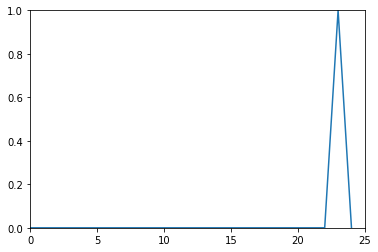

In [32]:
%matplotlib inline

def soluteTransportV2(concentrations):
    queue = np.copy(concentrations[:-1])
    concentrations[:-1] = 0
    concentrations[1:] += queue
    del queue
    
    return concentrations

concentrations = np.zeros(25)
concentrations[0] = 1
for i in range(23):
    concentrations = soluteTransportV2(concentrations)
    
print(concentrations)
    
plt.plot(concentrations)
plt.xlim(0,25)
plt.ylim(0,1)
plt.show()

### Model Analysis
<p>Now this model <u>does</u> model the translational motion of the concentration peak. At the moment, I have not included actual time steps. There's no way to incorporate the average velocity of the groundwater, but that could soon. Maybe I should create a class for each of these so that all of the values would be incorporated together instead of separate within the script.</p>
<p>I'll try creating a simple flow model class.</p>